# Проект

В данном проекте мы пытаемся понять, стоит ли давать человеку кредит. Для этого мы будем предсказывать вероятность того, что он не вернёт деньги.

## Список признаков

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отклонённых в прошлом заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту (наша целевая переменная)

In [1]:
import datetime

start = datetime.datetime.now()

#загрузка датасетов и библиотек

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

!pip freeze > requirements.txt

RANDOM_SEED = 42

train = pd.read_csv(r'c:\Users\akbear\skillfactory\Project05\files\train.csv', low_memory=False)
test = pd.read_csv(r'c:\Users\akbear\skillfactory\Project05\files\test.csv', low_memory=False)
sample_submission = pd.read_csv(r'c:\Users\akbear\skillfactory\Project05\files\sample_submission.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [2]:
test.info()

# видим, что на целевая переменая известна только для трейна, а на тесте её надо будет предсказать

# пропуски же имеются только в education

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

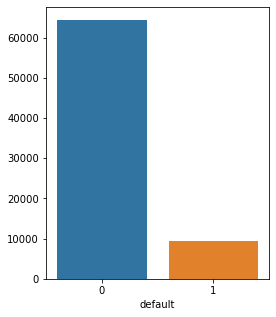

In [3]:
plt.figure(figsize=(4, 5))
ax = sns.countplot(x=train["default"])
ax.set(ylabel="");

#выборка скорее несбалансированная.

In [4]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

#бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time',
           'region_rating']

#числовые переменные
num_cols = ['age', 'bki_request_cnt', 'income', 'score_bki', 'decline_app_cnt']

In [6]:
'''преобразуем данные из app_date в datetime'''
test['app_date'] =  pd.to_datetime(test['app_date'], format='%d%b%Y')
train['app_date'] =  pd.to_datetime(train['app_date'], format='%d%b%Y')

In [7]:
train.app_date.min()

Timestamp('2014-01-01 00:00:00')

In [8]:
train.app_date.max()
#период небольшой, всего четыре месяца: с нового года по конец апреля.

Timestamp('2014-04-30 00:00:00')

In [9]:
#разобьем период на недели и присвоим каждому клиенту номер недели обращения 

from dateutil import rrule
import datetime
def weeks(app_date):
    weeks = rrule.rrule(rrule.WEEKLY, dtstart=train.app_date.min(), until=app_date)
    return weeks.count()

train['week'] = train['app_date'].apply(weeks)
test['week'] = test['app_date'].apply(weeks)

train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,week
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,5
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,11
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,5
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,4
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,16


In [10]:
train['week'].value_counts(ascending=False)

11    5466
14    5047
5     4931
12    4890
4     4773
13    4754
9     4714
3     4641
6     4478
7     4448
8     4391
10    4360
15    4282
16    3730
2     3549
17    3226
1     1535
18     584
Name: week, dtype: int64

In [11]:
week_default = train.copy()[train.default == 1]
week_default = train.groupby(['week'])['default'].sum()
week_default.sort_values(ascending=False)

week
11    707
4     690
5     679
14    631
9     623
3     619
13    613
12    611
8     607
7     586
6     571
10    551
2     509
15    427
16    331
17    302
1     252
18     63
Name: default, dtype: int64

In [12]:
#создадим столбец с днем недели на момент обращения

train['day_of_week'] = train['app_date'].dt.dayofweek
test['day_of_week'] = test['app_date'].dt.dayofweek

train['day_of_week'].value_counts()

1    12176
0    12024
2    11740
3    11615
4    11263
5     8231
6     6750
Name: day_of_week, dtype: int64

In [13]:
day_default = train.copy()[train.default == 1]
day_default = day_default.groupby(['day_of_week'])['default'].sum()
day_default.sort_values(ascending=True)

#количество дефолтов по дням недели распределено вообще равномерно (с закономерной просадкой в воскресенье,
# когда и количество заявок минимально)

day_of_week
6     872
5    1078
4    1351
2    1459
0    1528
3    1533
1    1551
Name: default, dtype: int64

In [14]:
cat_cols.append("day_of_week")
cat_cols.append("week")

In [15]:
#преобразуем столбец education

train.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

Система уровней образования в США состоит из среднего (school), бакалавриата (undergraduate), магистратуры (graduate) и докторантуры (postgraduate). ACD, скорее всего, это Assoсciate Degree - среднепрофессиональный уровень.

- SCH - 0
- UGR - 1
- ACD - 1 или 2
- GRD - 2 
- PGR - 3

In [16]:
#проверим по медианной зарплате

edu_income = train.groupby(['education'])['income'].median()
edu_income.sort_values(ascending=False)

education
ACD    60000.0
PGR    60000.0
GRD    40000.0
UGR    30000.0
SCH    25000.0
Name: income, dtype: float64

доходы у людей с уровнем ACD самые высокие (так что это, видимо, academic - профессура)

In [17]:
train.education.replace(('SCH', 'UGR', 'GRD', 'PGR', 'ACD' ), (1, 2, 3, 4, 5), inplace=True)
test.education.replace(('SCH', 'UGR', 'GRD', 'PGR', 'ACD' ), (1, 2, 3, 4, 5), inplace=True)

train.education = train.education.fillna(train.education.median()) #присвоим пропускам медианное значение
test.education = test.education.fillna(train.education.median()) 

train.education.value_counts()

1.0    39167
3.0    23365
2.0     9816
4.0     1257
5.0      194
Name: education, dtype: int64

In [18]:

income_age = train.groupby('age')['income'].mean().to_dict()

train['income_age'] = train['age'].map(income_age)
test['income_age'] = test['age'].map(income_age)
num_cols.append("income_age")

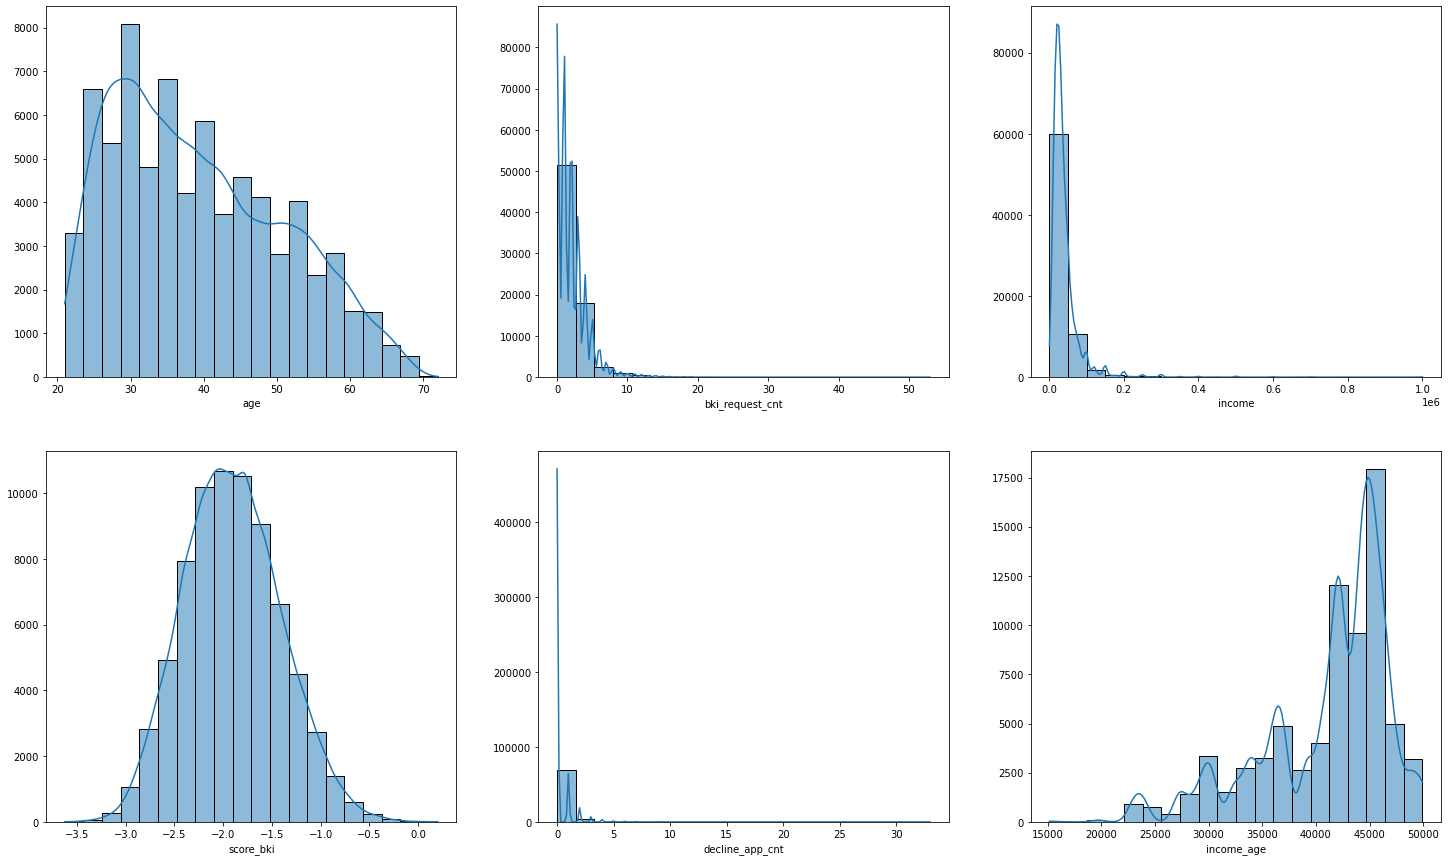

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i, col in enumerate(num_cols):
    hist = sns.histplot(train[col], bins=20, kde=True, ax=axes.flat[i])
    hist.set(ylabel="")

Построим графики распределения логарифмированных переменных, чтобы переменные стали менее смещенными.

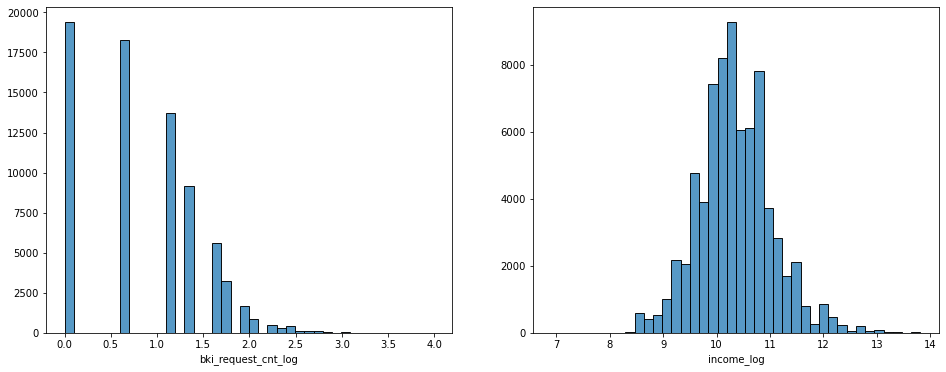

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, col in enumerate(["bki_request_cnt", "income"]):
    num_cols.append(f"{col}_log")
    train[f"{col}_log"] = np.log(train[col] + 1)
    test[f"{col}_log"] = np.log(test[col] + 1)
    hist = sns.histplot(train[f"{col}_log"], bins=40, ax=axes.flat[i], kde=False)
    hist.set(ylabel="")

In [21]:
train['inc_edu'] = train['income_log']*train['education']
test['inc_edu'] = test['income_log']*test['education']
num_cols.append('inc_edu')

In [22]:
train.decline_app_cnt.value_counts() #есть смысл преобразовать этот признак в бинарный
# по принципу "нет отказов"/"есть отказы" или "нет отказов"/"1"/"2 и больше"

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
14        2
12        2
16        2
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

<AxesSubplot:>

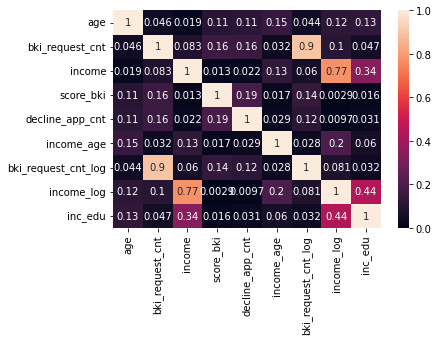

In [23]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

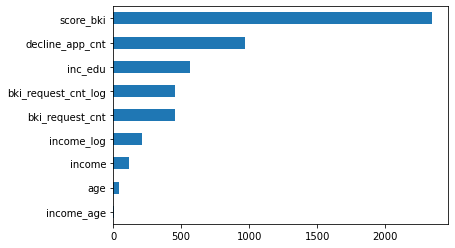

In [24]:
from sklearn.feature_selection import f_classif

imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [25]:
#for column in bin_cols:
#    print(train[column].unique())

In [26]:
# преобразуем бинарные признаки в формат 0-1

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

# убедимся в преобразовании    
train.head()

print(dict(enumerate(label_encoder.classes_)))

{0: 'N', 1: 'Y'}


In [27]:
#добавим бинарный признак наличия высшего образования

train["higher"] = train["education"].apply(lambda x: '1' if x >= 3 else 0)
test["higher"] = test["education"].apply(lambda x: '1' if x >= 3 else 0)

bin_cols.append("higher")

In [28]:
#преобразуем decline_app_cnt

train[train.decline_app_cnt >= 2] = 1

test[test.decline_app_cnt >= 2] = 1

bin_cols.append("decline_app_cnt")
num_cols.remove("decline_app_cnt")

train.decline_app_cnt.value_counts()

0    61214
1    12585
Name: decline_app_cnt, dtype: int64

In [29]:
# трансформируем категориальные признаки

columns = ['first_time', 'sna', 'region_rating' ]

for column in columns:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])
    
train.sna.value_counts()

0    49288
3    10831
1     9896
2     3784
Name: sna, dtype: int64

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            73799 non-null  int64  
 1   app_date             73799 non-null  object 
 2   education            73799 non-null  float64
 3   sex                  73799 non-null  int32  
 4   age                  73799 non-null  int64  
 5   car                  73799 non-null  int32  
 6   car_type             73799 non-null  int32  
 7   decline_app_cnt      73799 non-null  int64  
 8   good_work            73799 non-null  int64  
 9   score_bki            73799 non-null  float64
 10  bki_request_cnt      73799 non-null  int64  
 11  region_rating        73799 non-null  int64  
 12  home_address         73799 non-null  int64  
 13  work_address         73799 non-null  int64  
 14  income               73799 non-null  int64  
 15  sna                  73799 non-null 

## ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

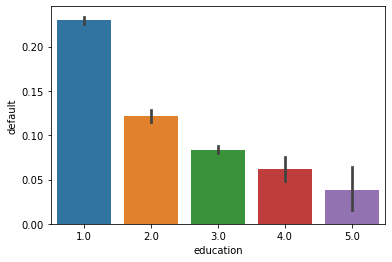

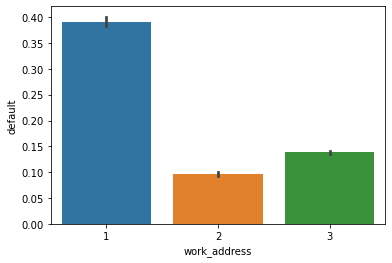

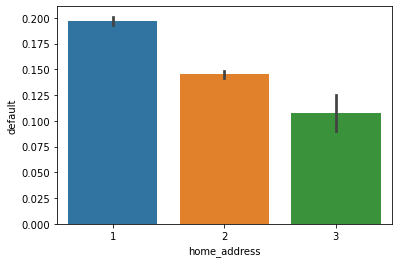

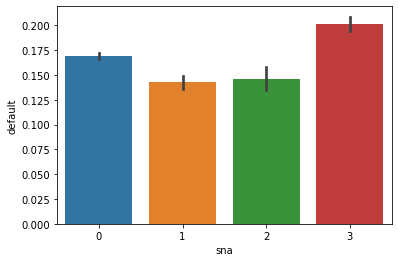

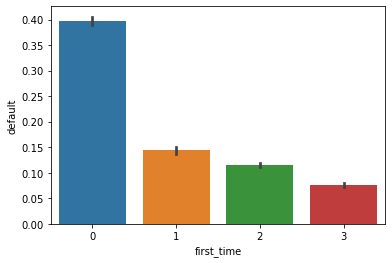

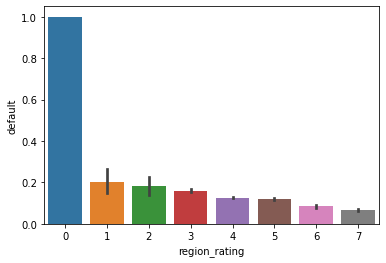

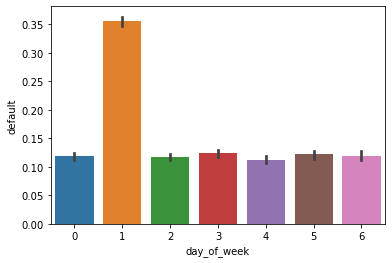

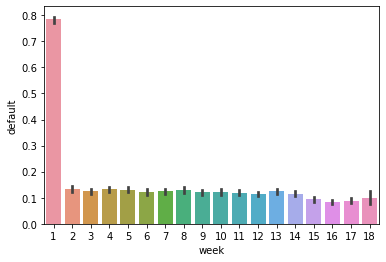

In [31]:
for col in cat_cols:
    sns.barplot(x=col, y="default", data=train[train["default"] >= 0])
    plt.show();
# клиенты с высшим образованием в среднем надёжнее,
# так же это относится и к region rating.
# так же удивили аномалии с днем недели (вторник) и первой (постновогодней) неделей. 

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

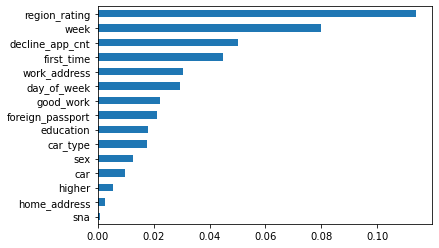

In [32]:
import pandas as pd
#import pandas.Series as Series
from sklearn.feature_selection import mutual_info_classif

imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Отбросим малозначимые и сильно скоррелированные признаки

In [33]:
print ('num_cols: ', num_cols)
print ('bin_cols: ', bin_cols)
print ('cat_cols: ', cat_cols)

num_cols:  ['age', 'bki_request_cnt', 'income', 'score_bki', 'income_age', 'bki_request_cnt_log', 'income_log', 'inc_edu']
bin_cols:  ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'higher', 'decline_app_cnt']
cat_cols:  ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating', 'day_of_week', 'week']


In [34]:
num_cols.remove('age')
#num_cols.remove('bki_request_cnt_log')
num_cols.remove('bki_request_cnt')
num_cols.remove('income')
#num_cols.remove('income_log')
num_cols.remove('inc_edu')
num_cols.remove('income_age')

bin_cols.remove('sex')
bin_cols.remove('car')
#bin_cols.remove('higher')
#bin_cols.remove('foreign_passport')

#cat_cols.remove('home_address')
#cat_cols.remove('first_time')
#cat_cols.remove('sna')
#cat_cols.remove('education')
#cat_cols.remove('day_of_week')
#cat_cols.remove('week')

print ('num_cols: ', num_cols)
print ('bin_cols: ', bin_cols)
print ('cat_cols: ', cat_cols)

num_cols:  ['score_bki', 'bki_request_cnt_log', 'income_log']
bin_cols:  ['car_type', 'good_work', 'foreign_passport', 'higher', 'decline_app_cnt']
cat_cols:  ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating', 'day_of_week', 'week']


# Подготовка данных к машинному обучению


In [35]:
from sklearn.preprocessing import OneHotEncoder

X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values) #обучающие признаки
x_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values) #целевые признаки 


In [36]:
X_cat.shape

(73799, 52)

In [37]:
x_cat.shape

(36349, 52)

In [38]:
from sklearn.preprocessing import StandardScaler

# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(train[num_cols].values) #обучающие признаки
x_num = StandardScaler().fit_transform(test[num_cols].values) #целевые признаки

In [39]:
#И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные
#в одно признаковое пространство, разделив при этом признаки и целевую переменную.

X_train = np.hstack([X_num, train[bin_cols].values, X_cat]) #"обучающие" признаки
y_train = train['default'].values # целевой параметр 
X_pred = np.hstack([x_num, test[bin_cols].values, x_cat]) #целевые признаки

# выделим 20% данных train на валидацию
X_learn, X_val, y_learn, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

# Обучение и оптимизация модели

In [40]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score  

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, precision_recall_curve

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_learn, y_learn)
prob = model.predict_proba(X_val)[:, 1]

threshold = 0.159 #подбирается перебором с целью минимизации количества FN

y_test = prob

y_test[y_test >= threshold] = 1
y_test[y_test < threshold] = 0 

print('accuracy = ', np.round(accuracy_score(y_val, y_test), 3))

#print('f1_score = ', np.round(f1_score(y_val, y_test), 3))

confusion_matrix(y_val, y_test)

accuracy =  0.771


array([[9710, 2618],
       [ 762, 1670]], dtype=int64)

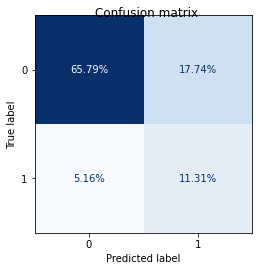

In [41]:
cm = confusion_matrix(y_val, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/np.sum(cm), display_labels=model.classes_)
disp.plot(cmap="Blues", colorbar=False, values_format=".2%")
plt.suptitle("Confusion matrix", x=.52, y=.91);

In [42]:
print(classification_report(y_val, y_test))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85     12328
           1       0.39      0.69      0.50      2432

    accuracy                           0.77     14760
   macro avg       0.66      0.74      0.67     14760
weighted avg       0.84      0.77      0.79     14760



In [43]:
print(roc_auc_score(y_val, y_test))

0.7371577645240617


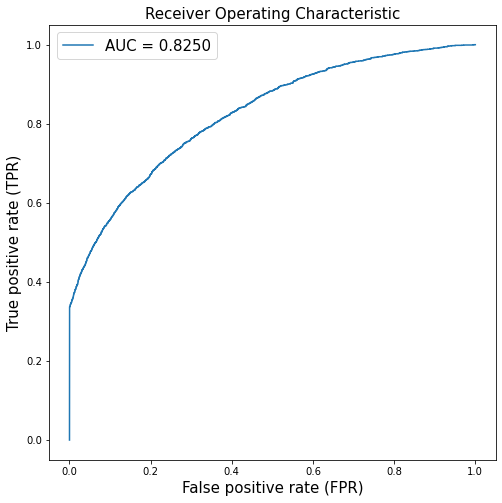

In [44]:
# Отрисовать ROC кривую
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from matplotlib import pyplot as plt

# Посчитать значения ROC кривой и значение площади под кривой AUC
fpr, tpr, thresholds = roc_curve(y_val,model.predict_proba(X_val).T[1])
roc_auc = roc_auc_score(y_val,model.predict_proba(X_val).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

In [45]:
from sklearn.model_selection import GridSearchCV

# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_learn, y_learn)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


In [52]:
#применим гиперпараметры
model1 = LogisticRegression(warm_start=False, verbose=0, tol=0.001, solver='lbfgs', random_state=None,
                          penalty='l2', n_jobs=None, multi_class='auto', max_iter=50, l1_ratio=None,
                          intercept_scaling=1, fit_intercept=True, dual=False, class_weight='none', C=1.0)
model1.fit(X_learn, y_learn)
prob = model1.predict_proba(X_val)[:, 1]

threshold = 0.159

prob[prob >= threshold] = 1
prob[prob < threshold] = 0 

y_test1 = prob

accuracy = accuracy_score(y_val, y_test1)
print('accuracy = ', np.round(accuracy, 3))

print('f1_score = ', np.round(f1_score(y_val, y_test1), 3))

confusion_matrix(y_val, y_test1)

accuracy =  0.771
f1_score =  0.497


array([[9707, 2621],
       [ 761, 1671]], dtype=int64)

In [53]:
print(roc_auc_score(y_val, y_test1))

0.7372416823918166


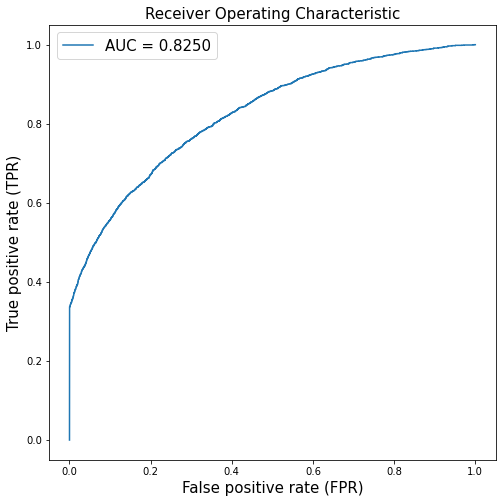

In [54]:
# Отрисовать ROC кривую
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from matplotlib import pyplot as plt

# Посчитать значения ROC кривой и значение площади под кривой AUC
fpr, tpr, thresholds = roc_curve(y_val,model1.predict_proba(X_val).T[1])
roc_auc = roc_auc_score(y_val,model1.predict_proba(X_val).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_test1))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85     12328
           1       0.39      0.69      0.50      2432

    accuracy                           0.77     14760
   macro avg       0.66      0.74      0.67     14760
weighted avg       0.84      0.77      0.79     14760



# Финальное предсказание

In [56]:
y = model1.predict_proba(X_pred)[:, 1]
y[y >= threshold] = 1
y[y < threshold] = 0 

sample_submission['default'] = y.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [51]:
end = datetime.datetime.now()

print(end - start)

0:01:59.786265
